In [2]:
from google.colab import drive
drive.mount('/content/drive')

!cp -r /content/skin_diseases_images /content/drive/MyDrive/


Mounted at /content/drive
cp: cannot stat '/content/skin_diseases_images': No such file or directory


In [4]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ayberkpalta","key":"20d984e0e0893aaddfe3a583d4c792e9"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d ismailpromus/skin-diseases-image-dataset
!unzip -q skin-diseases-image-dataset.zip -d skin_diseases_images


Dataset URL: https://www.kaggle.com/datasets/ismailpromus/skin-diseases-image-dataset
License(s): copyright-authors
100% 5.18G/5.19G [00:57<00:00, 46.4MB/s]
100% 5.19G/5.19G [01:02<00:00, 88.8MB/s]


In [ ]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.layers import Conv2D, AveragePooling2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.layers import RandomBrightness, RandomFlip, RandomRotation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import os
import warnings
warnings.filterwarnings('ignore')

In [8]:
import os
import random
import numpy as np
import tensorflow as tf
from sklearn.utils import class_weight

from tensorflow.keras.applications.resnet import ResNet152, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Sabitler
SEED = 42
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Dataset yolu ve sınıflar
path = "/content/skin_diseases_images"
classes_dir = os.path.join(path, 'IMG_CLASSES')
classes = sorted(os.listdir(classes_dir))
print("Classes:", classes)

class_index = {name: i for i, name in enumerate(classes)}
print("Class index dictionary:", class_index)

# Görüntü işleme fonksiyonu
def process_image(file_path, label):
    label = tf.cast(label, tf.int32)
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (224, 224))
    image = preprocess_input(image)  # ResNet için preprocess
    return image, label

# Dataset oluşturma fonksiyonu
def make_dataset(data):
    files = [f for f, _ in data]
    labels = [class_index[l] for _, l in data]
    ds = tf.data.Dataset.from_tensor_slices((files, labels))
    ds = ds.map(process_image, num_parallel_calls=AUTOTUNE)
    ds = ds.shuffle(1000, seed=SEED).batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

# Veri listelerini hazırla
train_data = []
val_data = []
test_data = []

for class_name in classes:
    images = os.listdir(os.path.join(classes_dir, class_name))

    train_num = int(0.8 * len(images))
    val_num = int(0.1 * len(images))

    train_imgs = random.sample(images, train_num)
    val_imgs = random.sample(list(set(images) - set(train_imgs)), val_num)
    test_imgs = list(set(images) - set(train_imgs) - set(val_imgs))

    for img_name in train_imgs:
        train_data.append((os.path.join(classes_dir, class_name, img_name), class_name))
    for img_name in val_imgs:
        val_data.append((os.path.join(classes_dir, class_name, img_name), class_name))
    for img_name in test_imgs:
        test_data.append((os.path.join(classes_dir, class_name, img_name), class_name))

random.shuffle(train_data)
random.shuffle(val_data)
random.shuffle(test_data)

# TensorFlow Dataset oluştur
train_ds = make_dataset(train_data)
val_ds = make_dataset(val_data)
test_ds = make_dataset(test_data)

# Class weights hesapla
train_labels = np.array([class_index[label] for _, label in train_data])
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(weights))
print('Class weights:', class_weights)

# Model oluştur
base_model = ResNet152(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

num_classes = len(classes)
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.35)(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

# Öğrenme oranı düşürme callback'i
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

# Model derleme
model.compile(
    optimizer=Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


Classes: ['1. Eczema 1677', '10. Warts Molluscum and other Viral Infections - 2103', '2. Melanoma 15.75k', '3. Atopic Dermatitis - 1.25k', '4. Basal Cell Carcinoma (BCC) 3323', '5. Melanocytic Nevi (NV) - 7970', '6. Benign Keratosis-like Lesions (BKL) 2624', '7. Psoriasis pictures Lichen Planus and related diseases - 2k', '8. Seborrheic Keratoses and other Benign Tumors - 1.8k', '9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k']
Class index dictionary: {'1. Eczema 1677': 0, '10. Warts Molluscum and other Viral Infections - 2103': 1, '2. Melanoma 15.75k': 2, '3. Atopic Dermatitis - 1.25k': 3, '4. Basal Cell Carcinoma (BCC) 3323': 4, '5. Melanocytic Nevi (NV) - 7970': 5, '6. Benign Keratosis-like Lesions (BKL) 2624': 6, '7. Psoriasis pictures Lichen Planus and related diseases - 2k': 7, '8. Seborrheic Keratoses and other Benign Tumors - 1.8k': 8, '9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k': 9}
Class weights: {0: np.float64(1.6196122296793438), 1: n

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 59,553,930 (227.18 MB)

 Trainable params: 18,133,514 (69.17 MB)

 Non-trainable params: 41,420,416 (158.01 MB)

Epoch 1/9
679/679 ━━━━━━━━━━━━━━━━━━━━ 307s 370ms/step - accuracy: 0.5965 - loss: 1.2865 - val_accuracy: 0.7241 - val_loss: 1.0193 - learning_rate: 0.0010
Epoch 2/9
679/679 ━━━━━━━━━━━━━━━━━━━━ 273s 328ms/step - accuracy: 0.7657 - loss: 0.8049 - val_accuracy: 0.7053 - val_loss: 1.0675 - learning_rate: 0.0010
Epoch 3/9
679/679 ━━━━━━━━━━━━━━━━━━━━ 264s 330ms/step - accuracy: 0.8315 - loss: 0.5785 - val_accuracy: 0.7986 - val_loss: 0.6502 - learning_rate: 0.0010
Epoch 4/9
679/679 ━━━━━━━━━━━━━━━━━━━━ 259s 328ms/step - accuracy: 0.8881 - loss: 0.3819 - val_accuracy: 0.7949 - val_loss: 0.7440 - learning_rate: 0.0010
Epoch 5/9
679/679 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.9269 - loss: 0.2460
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
679/679 ━━━━━━━━━━━━━━━━━━━━ 268s 334ms/step - accuracy: 0.9269 - loss: 0.2460 - val_accuracy: 0.8071 - val_loss: 0.7360 - learning_rate: 0.0010
Epoch 6/9
679/679 ━━━━━━━━━━━━━━━━━━━━ 271s 350ms/step - accuracy: 0.96

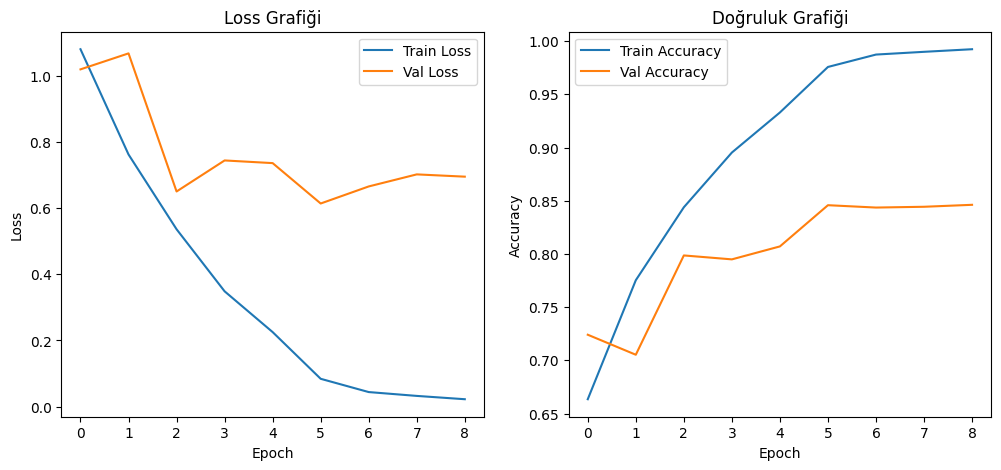

86/86 ━━━━━━━━━━━━━━━━━━━━ 32s 308ms/step - accuracy: 0.8563 - loss: 0.6681
Test Loss: 0.6997
Test Accuracy: 0.8487


In [9]:
# Model eğitimi
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=9,
    class_weight=class_weights,
    callbacks=[lr_scheduler]
)

# Eğitim sonuçlarını grafikle gösterme
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Loss grafiği
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Grafiği')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Doğruluk grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Doğruluk Grafiği')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Test seti üzerinde değerlendirme
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


In [10]:
!cp -r /content/skin_diseases_images /content/drive/MyDrive/

In [12]:
model.save("my_model.h5")


In [13]:
model.save("DermNet.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

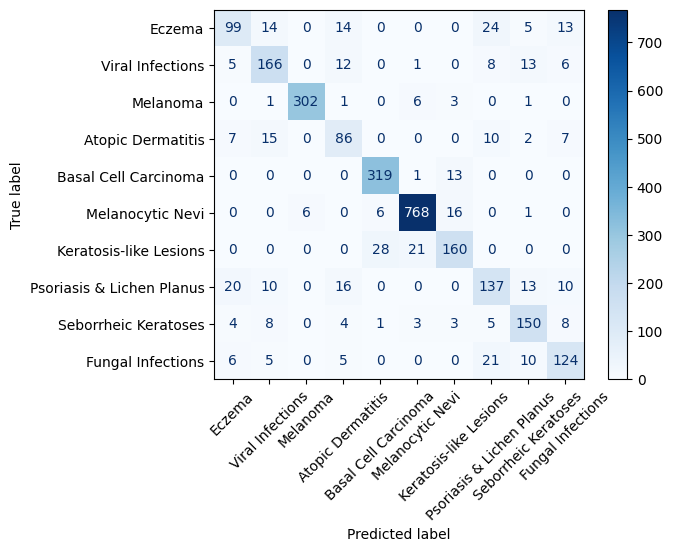

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Get ground truth and predictions
y_true = []
y_pred = []

for batch_imgs, batch_labels in test_ds:
    preds = model.predict(batch_imgs)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(batch_labels.numpy())

# Confusion matrix
class_names = [ # List of class names in correct index order
    "Eczema",
    "Viral Infections",
    "Melanoma",
    "Atopic Dermatitis",
    "Basal Cell Carcinoma",
    "Melanocytic Nevi",
    "Keratosis-like Lesions",
    "Psoriasis & Lichen Planus",
    "Seborrheic Keratoses",
    "Fungal Infections"
]
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=class_names).plot(xticks_rotation=45, cmap='Blues')
plt.show()

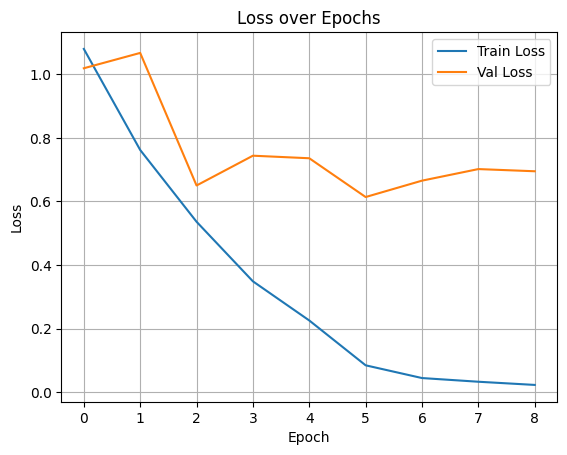

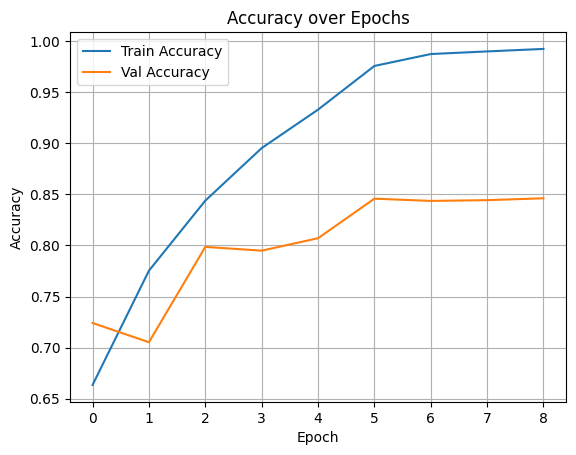

In [15]:
# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
!nvidia-smi


Tue Jul  8 14:53:48 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   72C    P0             32W /   70W |    8318MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----